# face detection using Tensorflow

In [31]:
import sys
import time
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import cv2
import functions as fn
import webcolors

sys.path.append("./")
sys.path.append("./utils/")
sys.path.append("./protos/")
import label_map_util
import visualization_utils_color as vis_util

disp_height=1080/1.55
disp_width=1920/1.55

try:
    import google.colab
    IN_COLAB = True
    %matplotlib inline
    from google.colab import drive
    from google.colab.patches import cv2_imshow
    drive.mount('/content/gdrive')
    DRIVE_ROOT='/content/gdrive/My Drive/opencv/'
    !pip install face_recognition
except:
    IN_COLAB =False
    %matplotlib notebook  
    DRIVE_ROOT='./'
PATH_TO_CKPT = os.path.join(DRIVE_ROOT,'model/frozen_inference_graph_face.pb')
PATH_TO_LABELS = os.path.join(DRIVE_ROOT,'protos/face_label_map.pbtxt')
DIR_KNOWN_FACE = os.path.join(DRIVE_ROOT,'known_face/')
OUT_DIR = os.path.join(DRIVE_ROOT,'media/')

NUM_CLASSES = 2

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map,max_num_classes=NUM_CLASSES,use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width,im_height) = image.size
    return np.array(image.getdata()).reshape((im_height,im_width, 3)).astype(np.uint8)


In [2]:
import face_recognition
known_face_names = []
known_face_encodings = []

def scan_known_faces(known_people_folder):
    image_files_in_folder = os.listdir(known_people_folder)
    for name in image_files_in_folder:
        if name.startswith("."):
            continue
        file=os.path.join(known_people_folder,name)
        basename = os.path.splitext(os.path.basename(file))[0]
        img = face_recognition.load_image_file(file)
        encodings = face_recognition.face_encodings(img)

        if len(encodings) > 1:
            click.echo("WARNING: More than one face found in {}. Only considering the first face.".format(file))

        if len(encodings) == 0:
            click.echo("WARNING: No faces found in {}. Ignoring file.".format(file))
        else:
            known_face_names.append(basename)
            known_face_encodings.append(encodings[0])

    return known_face_names, known_face_encodings

scan_known_faces(DIR_KNOWN_FACE)            
print(known_face_names)

['Asako', 'Aya', 'ClassMate1', 'ClassMate2', 'Girl1', 'Jiro', 'Saki', 'Suzu', 'Toma']


In [32]:
font = cv2.FONT_HERSHEY_PLAIN
font_scale = 1.2
thickness = 2

def calc_resize(image,size=None,DEBUG=False):
    if size is None:
        im_height,im_width = image.shape[:2]
    else:
        (im_width,im_height) = size
    if DEBUG:
        print('w',im_width,'h',im_height)
    if im_height>disp_height or im_width>disp_width:
        ratio =min(disp_height/im_height,disp_width/im_width)
        if DEBUG:
            print('r',ratio)
        im_height=int(im_height*ratio)
        im_width=int(im_width*ratio)
    else:
        ratio=1
    if DEBUG:
        print('w',im_width,'h',im_height)
    return (im_width,im_height),ratio

def recognize(image,face_locations,threshold=0.6):
    face_names=[]
    frame = image[:,:,::-1]
    face_encodings = face_recognition.face_encodings(image,face_locations)
    for face_encoding in face_encodings:
        matches = face_recognition.compare_faces(known_face_encodings,face_encoding)
        name = 'unknown'
        
        face_distance = face_recognition.face_distance(known_face_encodings,face_encoding)
        best_match_index = np.argmin(face_distance)
        if matches[best_match_index]:
            if face_distance[best_match_index]<threshold:
                name = known_face_names[best_match_index]
            else:
                name = '?'+known_face_names[best_match_index]+'?'
        face_names.append(name)
    return face_names

def name_to_bgr(name):
    (r,g,b)=webcolors.name_to_rgb(name)
    return (b,g,r)

def get_detection_graph():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

def boxes_to_face_locations(boxes,scores,image_height,image_width,threshold=0.7):
    # print('threshold',threshold,'boxes',len(boxes))
    face_locations=[]
    for i in range(len(boxes)):
        if scores[i]>threshold:
            #print(i,scores[i])
            ymin,xmin,ymax,xmax = boxes[i]
            top = int(image_height*ymin)
            left=int(image_width*xmin)
            bottom=int(image_height*ymax)
            right=int(image_width*xmax)
            face_locations.append((top,right,bottom,left))
            #(top,right,bottom,left)=face_location;
    #print('face_locations',len(face_locations))
    return face_locations

def resize_showimage(in_image,face_locations,face_names,size=None,ratio=None,DEBUG=False,time_stamp=None):
    if ratio is None or size is None:
        size,ratio = calc_resize(in_image)
    if DEBUG:
        print(size,ratio)
    image=cv2.resize(in_image,size)
    b_bgr=name_to_bgr('blue')
    w_bgr=name_to_bgr('white')
    r_bgr=name_to_bgr('red')
    l_bgr=name_to_bgr('lime')
    if time_stamp is not None:
        t_size = cv2.getTextSize(time_stamp,font,font_scale,thickness)
        t_h=t_size[0][1]
        cv2.putText(image, time_stamp, (0,t_h), font,font_scale, l_bgr, thickness)

    for i in range(len(face_locations)):
        face_location=face_locations[i]
        (top,right,bottom,left)=face_location;
        top = int(top*ratio)
        right=int(right*ratio)
        bottom=int(bottom*ratio)
        left=int(left*ratio)
        name=face_names[i]
        if name == 'Toma':
            col=r_bgr
        else:
            col=b_bgr
        image=cv2.resize(image,size)
        cv2.rectangle(image, (left,top), (right,bottom), col,thickness)
        text_size = cv2.getTextSize(name, font, font_scale, thickness)
        text_width = text_size[0][0]
        text_height = text_size[0][1]
        
        cv2.rectangle(image, (left, bottom), (left+text_width+thickness, bottom+text_height+thickness), col, cv2.FILLED)
        cv2.putText(image, name, (left,bottom + text_height), font,font_scale, w_bgr, thickness)
    return image

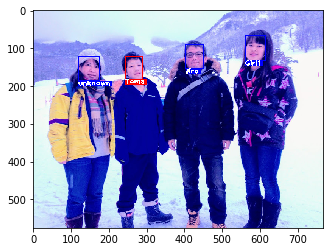

In [28]:
def detect(image,detection_graph,sess):
    image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
    image_np_expanded = np.expand_dims(image_np,axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    start_time = time.time()
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes,scores,classes,num_detections],
        feed_dict={image_tensor: image_np_expanded}
    )
    elapsed_time = time.time() - start_time
    #print('inteference time cost: {}'.format(elapsed_time))
    boxes=np.squeeze(boxes)
    scores=np.squeeze(scores)
    classes=np.squeeze(classes)
    im_height,im_width = image.shape[:2]
            
    face_locations = boxes_to_face_locations(boxes,scores,im_height,im_width)
    #face_names=recognize(image,face_locations)
    #image=resize_showimage(image,face_locations,face_names)
    return face_locations


def detect_face_tf(image):
    detection_graph=get_detection_graph()
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            #image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            #image_np_expanded = np.expand_dims(image_np,axis=0)
            #image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
            #boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            #scores = detection_graph.get_tensor_by_name('detection_scores:0')
            #classes = detection_graph.get_tensor_by_name('detection_classes:0')
            #num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            #start_time = time.time()
            #(boxes, scores, classes, num_detections) = sess.run(
            #    [boxes,scores,classes,num_detections],
            #    feed_dict={image_tensor: image_np_expanded}
            #)
            #elapsed_time = time.time() - start_time
            #print('inteference time cost: {}'.format(elapsed_time))
            #boxes=np.squeeze(boxes)
            #scores=np.squeeze(scores)
            #classes=np.squeeze(classes)
            #im_height,im_width = image.shape[:2]
            
            #face_locations = boxes_to_face_locations(boxes,scores,im_height,im_width)
            face_locations = detect(image,detection_graph,sess)
            face_names=recognize(image,face_locations)
            image=resize_showimage(image,face_locations,face_names)
            return image

#file_name="./test-data/img_report.jpg"
#file_name="./test-data/IMG_5710.JPG" # k family
#file_name="./test-data/12.jpg" # N family
file_name="./test-data/IMG_4523.JPG" # family
image = cv2.imread(file_name)
image=detect_face_tf(image)

#sz,ratio = calc_resize(image)
#image=cv2.resize(image,sz)
cv2.imshow("test",image)

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cv2.waitKey(0) & 0xFF
cv2.destroyAllWindows()

In [38]:
def recognize_movie(video_file,output_file=None,view=True):
    # input
    cap = cv2.VideoCapture(video_file)
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count=0
    i_fps=round(fps)
    #print('fps',i_fps)
    interval,time_wait = fn.getInterval(fps)
    show_size,show_ratio = calc_resize(None,(video_width,video_height))

    # output
    if output_file is not None:
        bd=os.path.splitext(os.path.basename(video_file))[0]
        cap_dir=os.path.join(OUT_DIR,bd)
        os.makedirs(cap_dir,exist_ok=True)
        output_file=os.path.join(OUT_DIR,bd+'.avi')
        if IN_COLAB:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        else:
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(output_file, fourcc, fps, (video_width, video_height))
    else:
        writer = None

    # ready for tensorflow
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            while cap.isOpened():
                ret,frame = cap.read()
                if not ret:
                    cap.release()
                    break
                frame_count+=1
                
                s,fr=divmod(frame_count,i_fps)
                m,s=divmod(s,60)
                ts='{:02d}:{:02d}.{:d}/{:d}'.format(m,s,fr,i_fps)
                face_locations = detect(frame,detection_graph,sess)
                face_names=recognize(frame,face_locations)
                if writer is not None:
                    write_image=resize_showimage(frame,face_locations,face_names,(video_width,video_height),1.0,time_stamp=ts)
                    writer.write(write_image)
                    if 'Toma' in face_names:
                        cap_name='{:02d}m_{:02d}s_{:d}'.format(m,s,fr)+'.png'
                        print(ts,cap_name)
                        cv2.imwrite(os.path.join(cap_dir,cap_name),write_image)
                if not IN_COLAB and view:
                    img = resize_showimage(frame,face_locations,face_names,show_size,show_ratio,time_stamp=ts)
                    cv2.imshow("detect_by_tensorflow",img)
                    k=cv2.waitKey(time_wait) & 0xFF
                    if k==27:
                        break;
            cv2.destroyAllWindows()
            cap.release()
v_file=os.path.join(DRIVE_ROOT,'gassou_15sec_small.mp4')
#v_file=os.path.join(DRIVE_ROOT,'gassou_15sec_large.mp4')
#o_file = './media/out_15_S.avi'

start_time = time.time()
recognize_movie(v_file,True,view=True)
elapsed_time = time.time() - start_time
print('elapsed time: {}'.format(elapsed_time))

interval:  0.04170833333333333 time_wait:  41
00:03.7/24 00m_03s_7.png
00:03.14/24 00m_03s_14.png
00:03.15/24 00m_03s_15.png
00:03.16/24 00m_03s_16.png
00:03.17/24 00m_03s_17.png
00:03.18/24 00m_03s_18.png
elapsed time: 100.3057074546814


In [22]:
# the original source from web
def origin_proc():
    cap = cv2.VideoCapture('./gassou_30sec_large.mp4')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval,time_wait = fn.getInterval(fps)
    out = None
    print('w:',width,'h:',height)

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        
    with detection_graph.as_default():
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(graph=detection_graph, config=config) as sess:
            frame_num = 1490
            while frame_num:
                frame_num-=1
                ret, image = cap.read()
                if ret == 0:
                    break
                if out is None:
                    #[h,w] = image.shape[:2]
                    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
                    #out = cv2.VideoWriter("./media/test_out.avi", 0,25.0, (w,h))
                    out = cv2.VideoWriter("./media/test_out.avi", fourcc, fps, (width, height))

                image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
                image_np_expanded = np.expand_dims(image_np,axis=0)
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
                boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
                scores = detection_graph.get_tensor_by_name('detection_scores:0')
                classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
                start_time = time.time()
                (boxes, scores, classes, num_detections) = sess.run(
                    [boxes,scores,classes,num_detections],
                    feed_dict={image_tensor: image_np_expanded}
                )
                elapsed_time = time.time() - start_time
                #print('inteference time cost: {}'.format(elapsed_time))
            
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=2
                )
                out.write(image)
                image=cv2.resize(image,(960,540))
                cv2.imshow("detect_by_tensorflow",image)
                k=cv2.waitKey(time_wait) & 0xFF
                if k==27:
                    break;

            cv2.destroyAllWindows()
            cap.release()
            out.release()